# Technical validation - part 2

This notebook prepares per-recording SNR/PSD features, normalizes them per patient,
and trains a simple baseline classifier (Random Forest) to distinguish healthy
from impaired arms.

## Prepare data

We calculate PSD and SNR statistics. The only difference to the statistical
analysis in part 1 is that we calculate statistics per recording and not per
patient.

In [1]:
import glob
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import signal
from tqdm import tqdm

DATA_DIR = Path(os.getenv("PHYSIOMIO_DATA_DIR", "data"))

all_parquet_files = glob.glob(str(DATA_DIR / "**/*.parquet"), recursive=True)
assert len(all_parquet_files) > 0, "No parquet files found under data"
print(f"Found {len(all_parquet_files)} parquet files under {DATA_DIR}")

Found 329 parquet files under data


In [2]:
def calculate_channel_mean_amplitude(
        df: pd.DataFrame,
        channel: str,
        movement_type_col: str = 'movement_type') -> tuple[dict[str, float], float, float]:
    """
    Calculate SNR statistics for a single channel using mean amplitude.

    Args:
        df: DataFrame containing the EMG data and movement labels
        channel: Name of the channel column to analyze
        movement_type_col: Name of the column containing movement labels

    Returns:
        tuple containing:
            - Dictionary mapping movement names to SNR values
            - Mean SNR across all movements (excluding Rest)
            - Standard deviation of SNR across movements
    """
    unique_movements = df[movement_type_col].unique()
    mean_amps = {}
    snr_values = {}

    # Calculate Rest mean amplitude first
    rest_mask = df[movement_type_col] == 'Rest'
    assert 'Rest' in unique_movements, "Rest movement must be present in the data"

    rest_ma = df.loc[rest_mask, channel].abs().mean()
    denom = max(rest_ma, np.finfo(float).eps)
    mean_amps['Rest'] = rest_ma

    # Calculate other mean amplitudes and SNR
    for movement in unique_movements:
        if movement == 'Rest':
            continue
        mask = df[movement_type_col] == movement
        ma = df.loc[mask, channel].abs().mean()
        mean_amps[movement] = ma
        # Using 20*log10 for amplitude ratio
        snr_values[movement] = 20 * np.log10(ma / denom)

    # Calculate average SNR and std dev
    snr_values_list = list(snr_values.values())
    avg_snr = float(np.mean(snr_values_list))
    std_snr = float(np.std(snr_values_list))

    return snr_values, avg_snr, std_snr


def calculate_overall_snr(df: pd.DataFrame, snr_calculator,
                          movement_type_col: str = 'movement_type') -> tuple[float, float, list[float], float]:
    """
    Calculate overall SNR across all channels

    Args:
        df: DataFrame containing the EMG data and movement labels
        snr_calculator: Function to calculate SNR statistics
        movement_type_col: Name of the column containing movement labels

    Returns:
        tuple containing:
            - Mean SNR across all channels and movements
            - Standard deviation of SNR across all channels and movements
            - List of all individual SNR values
            - Average mean amplitude across all channels
    """
    all_snr_values = []
    all_mean_amplitudes = []

    # Get all channel columns that exist in the DataFrame
    channel_cols = [col for col in df.columns if col.startswith('channel_')]

    for channel_name in channel_cols:
        # Calculate SNR for this channel
        snr_values, _, _ = snr_calculator(
            df, channel_name, movement_type_col)
        # Add all individual SNR values for this channel
        all_snr_values.extend(list(snr_values.values()))

        # Calculate mean amplitude for this channel across all data
        channel_mean_amplitude = df[channel_name].abs().mean()
        all_mean_amplitudes.append(channel_mean_amplitude)

    overall_mean_snr = float(np.mean(all_snr_values))
    overall_std_snr = float(np.std(all_snr_values))
    avg_mean_amplitude = float(
        np.mean(all_mean_amplitudes)) if all_mean_amplitudes else 0.0

    return overall_mean_snr, overall_std_snr, all_snr_values, avg_mean_amplitude


def get_detailed_snrs_df(parquet_files: list[str]):
    """
    Calculate detailed SNR statistics with one row per recording.

    Args:
        parquet_files: List of paths to parquet files containing EMG data

    Returns:
        pd.DataFrame: Detailed statistics with one row per recording showing
                     Patient, Recording, Arm Type, SNR Mean, and SNR Std Dev
    """
    rows = []

    for file in tqdm(parquet_files, desc="Processing recordings"):
        # Extract patient number
        patient_num = int(file.split('/patient')[1].split('/')[0])

        # Extract recording number from filename
        recording_name = Path(file).stem

        # Determine arm type
        if 'healthy_arm' in file:
            arm_type = 'Healthy'
        elif 'impaired_arm' in file:
            arm_type = 'Impaired'
        else:
            arm_type = 'Unknown'

        df = pd.read_parquet(file)
        snr_mean, snr_std, _, avg_mean_amplitude = calculate_overall_snr(
            df, snr_calculator=calculate_channel_mean_amplitude)

        rows.append({
            'Patient': patient_num,
            'Recording': recording_name,
            'Arm Type': arm_type,
            'SNR Mean (dB)': round(snr_mean, 2),
            'SNR Std Dev (dB)': round(snr_std, 2),
            'Avg Mean Amplitude': round(avg_mean_amplitude, 6)
        })

    # Create DataFrame and sort by Patient, then by Arm Type, then by Recording
    df_detailed = pd.DataFrame(rows)
    df_detailed = df_detailed.sort_values(['Patient', 'Arm Type', 'Recording'])

    return df_detailed


detailed_snrs_df = get_detailed_snrs_df(all_parquet_files)
snr_csv_filename = 'detailed_snrs_table.csv'
detailed_snrs_df.to_csv(snr_csv_filename, index=False)
print(f"\nSNR table saved to: {snr_csv_filename}")

print(f"\nSNR analysis complete!")

print(f"- Processed {len(all_parquet_files)} files")
print(f"- Generated table with {len(detailed_snrs_df)} recordings")
print(f"- Saved detailed results to {snr_csv_filename}")

Processing recordings: 100%|██████████| 329/329 [29:05<00:00,  5.31s/it]


SNR table saved to: detailed_snrs_table.csv

SNR analysis complete!
- Processed 329 files
- Generated table with 329 recordings
- Saved detailed results to detailed_snrs_table.csv


In [3]:
def min_max_normalize(series):
    """
    Apply min-max normalization to a pandas Series.

    Args:
        series: pandas Series to normalize

    Returns:
        pandas Series with values normalized to [0, 1] range
    """
    min_val = series.min()
    max_val = series.max()

    # Handle case where all values are the same (avoid division by zero)
    if max_val == min_val:
        return pd.Series([0.5] * len(series), index=series.index)

    return (series - min_val) / (max_val - min_val)


def normalize_snrs_by_patient(input_file='detailed_snrs_table.csv',
                              output_file='detailed_snrs_normalized_table.csv'):
    """
    Normalize SNR values by patient and save to new CSV file.

    For each patient, normalizes all their recordings (both healthy and impaired)
    based on that patient's min/max values across all their recordings.

    Args:
        input_file: Path to input CSV file
        output_file: Path to output CSV file
    """
    df = pd.read_csv(input_file)

    print(f"Loaded data with {len(df)} rows and {len(df.columns)} columns")
    print(f"Columns: {list(df.columns)}")
    print(f"Unique patients: {df['Patient'].nunique()}")

    # Create a copy for normalization
    df_normalized = df.copy()

    # Initialize normalized columns
    snr_mean_col = 'SNR Mean (dB)'
    snr_std_col = 'SNR Std Dev (dB)'

    df_normalized[f'{snr_mean_col} (Normalized)'] = 0.0
    df_normalized[f'{snr_std_col} (Normalized)'] = 0.0

    # Process each patient individually
    patients = sorted(df['Patient'].unique())
    print(f"\nProcessing {len(patients)} patients individually...")

    for patient_id in patients:
        # Get all recordings for this patient (both healthy and impaired)
        patient_mask = df['Patient'] == patient_id
        patient_data = df[patient_mask].copy()

        print(f"Patient {patient_id}: {len(patient_data)} recordings")

        # Normalize SNR Mean for this patient
        snr_mean_values = patient_data[snr_mean_col]
        normalized_mean = min_max_normalize(snr_mean_values)
        df_normalized.loc[patient_mask,
                          f'{snr_mean_col} (Normalized)'] = normalized_mean

        # Normalize SNR Std Dev for this patient
        snr_std_values = patient_data[snr_std_col]
        normalized_std = min_max_normalize(snr_std_values)
        df_normalized.loc[patient_mask,
                          f'{snr_std_col} (Normalized)'] = normalized_std

    # Reorder columns to put normalized columns after original ones
    original_cols = df.columns.tolist()

    # Insert normalized columns after the original SNR columns
    snr_mean_idx = original_cols.index(snr_mean_col)
    snr_std_idx = original_cols.index(snr_std_col)

    final_cols = original_cols.copy()
    final_cols.insert(snr_mean_idx + 1, f'{snr_mean_col} (Normalized)')
    final_cols.insert(snr_std_idx + 2, f'{snr_std_col} (Normalized)')

    df_normalized = df_normalized[final_cols]

    df_normalized.to_csv(output_file, index=False)

    print(f"\nNormalization complete!")
    print(f"Output saved to: {output_file}")

    print(f"\nNormalization Statistics:")
    print(
        f"Original SNR Mean range: [{df[snr_mean_col].min():.2f}, {df[snr_mean_col].max():.2f}]")
    print(
        f"Original SNR Std Dev range: [{df[snr_std_col].min():.2f}, {df[snr_std_col].max():.2f}]")

    print(f"\nNormalized SNR Mean range: [{df_normalized[f'{snr_mean_col} (Normalized)'].min(
    ):.2f}, {df_normalized[f'{snr_mean_col} (Normalized)'].max():.2f}]")
    print(f"Normalized SNR Std Dev range: [{df_normalized[f'{snr_std_col} (Normalized)'].min(
    ):.2f}, {df_normalized[f'{snr_std_col} (Normalized)'].max():.2f}]")


normalize_snrs_by_patient()

Loaded data with 329 rows and 6 columns
Columns: ['Patient', 'Recording', 'Arm Type', 'SNR Mean (dB)', 'SNR Std Dev (dB)', 'Avg Mean Amplitude']
Unique patients: 48

Processing 48 patients individually...
Patient 1: 8 recordings
Patient 2: 8 recordings
Patient 3: 8 recordings
Patient 4: 9 recordings
Patient 5: 5 recordings
Patient 6: 5 recordings
Patient 7: 11 recordings
Patient 8: 3 recordings
Patient 9: 7 recordings
Patient 10: 10 recordings
Patient 11: 6 recordings
Patient 12: 11 recordings
Patient 13: 5 recordings
Patient 14: 4 recordings
Patient 15: 3 recordings
Patient 16: 4 recordings
Patient 17: 14 recordings
Patient 18: 4 recordings
Patient 19: 7 recordings
Patient 20: 3 recordings
Patient 21: 5 recordings
Patient 22: 6 recordings
Patient 23: 4 recordings
Patient 24: 5 recordings
Patient 25: 10 recordings
Patient 26: 9 recordings
Patient 27: 8 recordings
Patient 28: 9 recordings
Patient 29: 6 recordings
Patient 30: 4 recordings
Patient 31: 8 recordings
Patient 32: 14 recording

In [4]:
def preprocess_emg(data: np.ndarray, fs: float) -> np.ndarray:
    """
    Preprocess EMG data by applying a notch filter to remove 50 Hz power line noise
    and a high-pass filter to remove low-frequency drift.

    Args:
        data: numpy array of EMG data
    """
    notch_freq = 50.0
    quality_factor = 10.0
    b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)
    filtered_data = signal.filtfilt(b_notch, a_notch, data)

    high_pass_freq = 20.0
    b_high, a_high = signal.butter(4, high_pass_freq/(fs/2), btype='high')
    filtered_data = signal.filtfilt(b_high, a_high, filtered_data)

    return filtered_data


def compute_psd(data: np.ndarray, fs: float, nperseg: int = 1024) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the power spectral density of the data using Welch's method.

    Args:
        data: numpy array of EMG data
        fs: sampling frequency
        nperseg: number of points to use for each segment
    """
    nperseg = min(nperseg, len(data) // 2)
    if nperseg < 256:
        nperseg = 256

    f, Pxx = signal.welch(data, fs, nperseg=nperseg, scaling="density")
    return f, Pxx

# Fixed version of the PSD function


def get_detailed_psd_df_fixed(parquet_files: list[str], num_freq_bins: int = 40):
    """
    Calculate detailed PSD statistics with one row per recording (FIXED VERSION).

    Args:
        parquet_files: List of paths to parquet files containing EMG data
        num_freq_bins: Number of frequency bins to create for PSD features

    Returns:
        pd.DataFrame: Detailed PSD statistics with one row per recording showing
                     Patient, Recording, Arm Type, and PSD values in frequency bins
    """
    rows = []
    fs = 2048

    # Define frequency bins (20-500 Hz)
    freq_min, freq_max = 20, 500
    freq_bins = np.linspace(freq_min, freq_max, num_freq_bins + 1)

    # Create column names for frequency bins
    freq_columns = []
    for i in range(num_freq_bins):
        freq_start = freq_bins[i]
        freq_end = freq_bins[i + 1]
        freq_columns.append(f'PSD_{freq_start:.1f}-{freq_end:.1f}Hz')

    for file in tqdm(parquet_files, desc="Processing PSD for recordings"):
        # Extract patient number
        patient_num = int(file.split('/patient')[1].split('/')[0])

        recording_name = Path(file).stem

        if 'healthy_arm' in file:
            arm_type = 'Healthy'
        elif 'impaired_arm' in file:
            arm_type = 'Impaired'
        else:
            arm_type = 'Unknown'

        # Read data and calculate PSD for all channels
        df = pd.read_parquet(file)
        channel_psds = []
        frequencies = None

        for channel in df.columns:
            if channel.startswith('channel_'):
                channel_data = df[channel].values * 0.001
                processed_emg = preprocess_emg(channel_data, fs)
                f, Pxx = compute_psd(processed_emg, fs, nperseg=1024)
                channel_psds.append(Pxx)
                if frequencies is None:
                    frequencies = f  # identical across channels

        if not channel_psds:
            continue

        # frequencies set during channel loop above

        # Average PSD across all channels for this recording
        avg_psd = np.mean(channel_psds, axis=0)

        # Calculate power in each frequency bin
        psd_features = {}
        for i, col_name in enumerate(freq_columns):
            freq_start = freq_bins[i]
            freq_end = freq_bins[i + 1]

            # Find indices for this frequency range
            freq_mask = (frequencies >= freq_start) & (frequencies < freq_end)

            if np.any(freq_mask):
                # Calculate average power in this frequency bin
                bin_power = np.mean(avg_psd[freq_mask])
                psd_features[col_name] = bin_power  # Keep full precision
            else:
                psd_features[col_name] = 0.0

        row = {
            'Patient': patient_num,
            'Recording': recording_name,
            'Arm Type': arm_type,
        }
        row.update(psd_features)
        rows.append(row)

    # Create DataFrame and sort
    df_psd = pd.DataFrame(rows)
    df_psd = df_psd.sort_values(['Patient', 'Arm Type', 'Recording'])

    return df_psd


psd_df_complete = get_detailed_psd_df_fixed(
    all_parquet_files, num_freq_bins=20)

# Save the PSD table to CSV file
psd_csv_filename = 'detailed_psd_table.csv'
psd_df_complete.to_csv(psd_csv_filename, index=False)
print(f"\nPSD table saved to: {psd_csv_filename}")

Processing PSD for recordings: 100%|██████████| 329/329 [03:11<00:00,  1.72it/s]


PSD table saved to: detailed_psd_table.csv


In [5]:
def normalize_psd_by_patient(input_file='detailed_psd_table.csv',
                             output_file='detailed_psd_normalized_table.csv'):
    """
    Normalize PSD values by patient and save to new CSV file.

    For each patient, normalizes all their recordings (both healthy and impaired)
    based on that patient's min/max values across all their recordings.

    Args:
        input_file: Path to input CSV file
        output_file: Path to output CSV file
    """
    df = pd.read_csv(input_file)

    print(f"Loaded data with {len(df)} rows and {len(df.columns)} columns")
    print(f"Columns: {list(df.columns)}")
    print(f"Unique patients: {df['Patient'].nunique()}")

    # Identify PSD columns (all columns that start with 'PSD_')
    psd_columns = [col for col in df.columns if col.startswith('PSD_')]
    print(f"Found {len(psd_columns)} PSD frequency band columns")

    # Create a copy for normalization
    df_normalized = df.copy()

    # Initialize normalized columns
    for col in psd_columns:
        df_normalized[f'{col} (Normalized)'] = 0.0

    # Process each patient individually
    patients = sorted(df['Patient'].unique())
    print(f"\nProcessing {len(patients)} patients individually...")

    for patient_id in patients:
        # Get all recordings for this patient (both healthy and impaired)
        patient_mask = df['Patient'] == patient_id
        patient_data = df[patient_mask].copy()

        print(f"Patient {patient_id}: {len(patient_data)} recordings")

        # Normalize each PSD column for this patient
        for col in psd_columns:
            psd_values = patient_data[col]
            normalized_values = min_max_normalize(psd_values)
            df_normalized.loc[patient_mask,
                              f'{col} (Normalized)'] = normalized_values

    # Reorder columns to put normalized columns after original ones
    original_cols = df.columns.tolist()

    # Create new column order: original columns + all normalized columns
    normalized_cols = [f'{col} (Normalized)' for col in psd_columns]
    final_cols = original_cols + normalized_cols

    df_normalized = df_normalized[final_cols]

    df_normalized.to_csv(output_file, index=False)

    print(f"\nNormalization complete!")
    print(f"Output saved to: {output_file}")

    # Print some statistics
    print(f"\nNormalization Statistics:")
    # Show first 3 PSD columns as examples
    for i, col in enumerate(psd_columns[:3]):
        print(f"{col}:")
        print(f"  Original range: [{df[col].min():.2e}, {df[col].max():.2e}]")
        print(f"  Normalized range: [{df_normalized[f'{col} (Normalized)'].min():.2f}, {
              df_normalized[f'{col} (Normalized)'].max():.2f}]")

    if len(psd_columns) > 3:
        print(f"... and {len(psd_columns) - 3} more PSD frequency bands")


normalize_psd_by_patient()

Loaded data with 329 rows and 23 columns
Columns: ['Patient', 'Recording', 'Arm Type', 'PSD_20.0-44.0Hz', 'PSD_44.0-68.0Hz', 'PSD_68.0-92.0Hz', 'PSD_92.0-116.0Hz', 'PSD_116.0-140.0Hz', 'PSD_140.0-164.0Hz', 'PSD_164.0-188.0Hz', 'PSD_188.0-212.0Hz', 'PSD_212.0-236.0Hz', 'PSD_236.0-260.0Hz', 'PSD_260.0-284.0Hz', 'PSD_284.0-308.0Hz', 'PSD_308.0-332.0Hz', 'PSD_332.0-356.0Hz', 'PSD_356.0-380.0Hz', 'PSD_380.0-404.0Hz', 'PSD_404.0-428.0Hz', 'PSD_428.0-452.0Hz', 'PSD_452.0-476.0Hz', 'PSD_476.0-500.0Hz']
Unique patients: 48
Found 20 PSD frequency band columns

Processing 48 patients individually...
Patient 1: 8 recordings
Patient 2: 8 recordings
Patient 3: 8 recordings
Patient 4: 9 recordings
Patient 5: 5 recordings
Patient 6: 5 recordings
Patient 7: 11 recordings
Patient 8: 3 recordings
Patient 9: 7 recordings
Patient 10: 10 recordings
Patient 11: 6 recordings
Patient 12: 11 recordings
Patient 13: 5 recordings
Patient 14: 4 recordings
Patient 15: 3 recordings
Patient 16: 4 recordings
Patient 17

## Random Forest classifier

To arrive at a simple baseline classifier for healthy and impaired arms, we
train a random forest and report detailed metrics on model performance on
four of the features we extracted earlier:

- SNR mean (normalized per patient)
- SNR stddev (normalized per patient)
- PSD_68.0-92.0Hz (normalized per patient)
- PSD_236.0-260.0Hz (normalized per patient)

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    roc_auc_score,
    average_precision_score,
)

# Set random state for reproducibility
RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

print("Loading normalized data tables...")
psd_data = pd.read_csv('detailed_psd_normalized_table.csv')
snr_data = pd.read_csv('detailed_snrs_normalized_table.csv')
print(f"PSD data shape: {psd_data.shape}")
print(f"SNR data shape: {snr_data.shape}")
print(f"\nLabel distribution in PSD data:")
print(psd_data['Arm Type'].value_counts())

# Combine datasets and prepare features
print("Combining datasets...")

combined_data = pd.merge(
    psd_data,
    snr_data,
    on=['Patient', 'Recording', 'Arm Type'],
    how='inner'
)

print(f"Combined data shape: {combined_data.shape}")
print(f"Combined label distribution:")
print(combined_data['Arm Type'].value_counts())

feature_cols = [col for col in combined_data.columns if
                'SNR Mean (dB) (Normalized)' in col or
                'SNR Std Dev (dB) (Normalized)' in col or
                'PSD_68.0-92.0Hz (Normalized)' in col or
                'PSD_236.0-260.0Hz (Normalized)' in col]

X = combined_data[feature_cols].values
y = combined_data['Arm Type'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"PSD features: {len([c for c in feature_cols if 'PSD' in c])}")
print(f"SNR features: {len([c for c in feature_cols if 'SNR' in c])}")

# Patient-based train/test split function


def patient_based_split(combined_data, X, y, test_size=0.15, random_state=RANDOM_STATE):
    """
    Split data ensuring no patient appears in both train and test sets.
    """
    np.random.seed(random_state)

    # Get patient recording counts
    patient_data = (
        combined_data.groupby('Patient').agg({'Recording': 'count'})
        .rename(columns={'Recording': 'num_recordings'})
    )

    # Calculate target test size
    total_recordings = len(combined_data)
    target_test_recordings = int(total_recordings * test_size)

    # Select patients for test set using greedy approach
    patients_by_size = patient_data.sort_values(
        'num_recordings', ascending=False)
    remaining_patients = list(patients_by_size.index)

    best_test_patients = []
    best_diff = float('inf')

    # Try multiple random combinations to find best split
    for _ in range(100):  # Multiple random attempts
        np.random.shuffle(remaining_patients)
        current_test_patients = []
        current_count = 0

        for patient in remaining_patients:
            patient_recordings = patient_data.loc[patient, 'num_recordings']
            if current_count + patient_recordings <= target_test_recordings + 5:  # Allow small overshoot
                current_test_patients.append(patient)
                current_count += patient_recordings

                # If we're close enough, stop
                if abs(current_count - target_test_recordings) <= abs(best_diff):
                    if abs(current_count - target_test_recordings) < abs(best_diff):
                        best_test_patients = current_test_patients.copy()
                        best_diff = current_count - target_test_recordings

    test_patients = best_test_patients
    test_recordings_count = sum(
        patient_data.loc[p, 'num_recordings'] for p in test_patients)

    print(f"Selected {len(test_patients)} patients for test set")
    print(
        f"Test recordings: {test_recordings_count} ({test_recordings_count/total_recordings*100:.1f}%)")

    # Create train/test masks
    test_mask = combined_data['Patient'].isin(test_patients)
    train_mask = ~test_mask

    # Split the data
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = y[train_mask]
    y_test = y[test_mask]

    # Verify no patient overlap
    train_patients = set(combined_data[train_mask]['Patient'].unique())
    test_patients_actual = set(combined_data[test_mask]['Patient'].unique())
    overlap = train_patients.intersection(test_patients_actual)

    # Return patient IDs aligned to X_test row order
    test_patient_ids = combined_data.loc[test_mask, "Patient"].to_numpy()

    if overlap:
        print(f"WARNING: Patient overlap detected: {overlap}")
    else:
        print("✓ No patient overlap between train and test sets")

    return X_train, X_test, y_train, y_test, test_patient_ids


# Perform the split
print("Performing patient-based train/test split...")
X_train, X_test, y_train, y_test, test_patient_ids = patient_based_split(
    combined_data, X, y)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training label distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for label, count in zip(unique, counts):
    print(f" {label}: {count} ({count/len(y_train)*100:.1f}%)")

Loading normalized data tables...
PSD data shape: (329, 43)
SNR data shape: (329, 8)

Label distribution in PSD data:
Arm Type
Impaired    238
Healthy      91
Name: count, dtype: int64
Combining datasets...
Combined data shape: (329, 48)
Combined label distribution:
Arm Type
Impaired    238
Healthy      91
Name: count, dtype: int64

Feature matrix shape: (329, 4)
Number of features: 4
PSD features: 2
SNR features: 2
Performing patient-based train/test split...
Selected 8 patients for test set
Test recordings: 49 (14.9%)
✓ No patient overlap between train and test sets

Training set: 280 samples
Test set: 49 samples
Training label distribution:
 Healthy: 75 (26.8%)
 Impaired: 205 (73.2%)


In [7]:
def create_rf_model():
    """Create a RandomForestClassifier with consistent parameters."""
    return RandomForestClassifier(
        n_estimators=100,
        random_state=RANDOM_STATE,
        max_depth=1,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced'
    )


print("Scaling features and training Random Forest...")

rf_model = create_rf_model()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {test_accuracy:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

Scaling features and training Random Forest...

Test Accuracy: 0.878

Classification Report:
              precision    recall  f1-score   support

     Healthy      0.778     0.875     0.824        16
    Impaired      0.935     0.879     0.906        33

    accuracy                          0.878        49
   macro avg      0.857     0.877     0.865        49
weighted avg      0.884     0.878     0.879        49



In [8]:
def patient_based_cv_split(combined_data, n_splits=5, random_state=RANDOM_STATE):
    """
    Create cross-validation splits ensuring no patient appears in multiple folds.
    """
    np.random.seed(random_state)

    # Get unique patients
    unique_patients = combined_data['Patient'].unique()
    np.random.shuffle(unique_patients)

    # Split patients into folds
    fold_size = len(unique_patients) // n_splits
    patient_folds = []

    for i in range(n_splits):
        start_idx = i * fold_size
        if i == n_splits - 1:  # Last fold gets remaining patients
            end_idx = len(unique_patients)
        else:
            end_idx = (i + 1) * fold_size
        patient_folds.append(unique_patients[start_idx:end_idx])

    # Create train/validation indices for each fold
    cv_splits = []
    for i in range(n_splits):
        val_patients = patient_folds[i]
        val_mask = combined_data['Patient'].isin(val_patients)
        train_mask = ~val_mask

        train_indices = combined_data[train_mask].index.values
        val_indices = combined_data[val_mask].index.values

        cv_splits.append((train_indices, val_indices))

    return cv_splits


print("Performing cross-validation with patient-based splits...")

cv_splits = patient_based_cv_split(combined_data, n_splits=5)

cv_scores = []
cv_balanced_scores = []
for fold, (train_idx, val_idx) in enumerate(cv_splits):
    # Get train and validation data for this fold
    X_fold_train = X[train_idx]
    X_fold_val = X[val_idx]
    y_fold_train = y[train_idx]
    y_fold_val = y[val_idx]

    fold_model = create_rf_model()
    fold_model.fit(X_fold_train, y_fold_train)

    fold_pred = fold_model.predict(X_fold_val)
    fold_accuracy = accuracy_score(y_fold_val, fold_pred)
    fold_balanced = balanced_accuracy_score(y_fold_val, fold_pred)
    cv_scores.append(fold_accuracy)
    cv_balanced_scores.append(fold_balanced)

    print(
        f"Fold {fold + 1}: Accuracy={fold_accuracy:.3f}, BalancedAcc={fold_balanced:.3f}")

cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)
cv_mean_bal = np.mean(cv_balanced_scores)
cv_std_bal = np.std(cv_balanced_scores)

print(f"\nCross-Validation Results:")
print(f"Mean CV Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")
print(f"Mean CV BalancedAccuracy: {cv_mean_bal:.3f} ± {cv_std_bal:.3f}")
print(
    f"Individual fold scores (Accuracy): {[f'{score:.3f}' for score in cv_scores]}")
print(
    f"Individual fold scores (BalancedAcc): {[f'{score:.3f}' for score in cv_balanced_scores]}")

Performing cross-validation with patient-based splits...
Fold 1: Accuracy=0.840, BalancedAcc=0.855
Fold 2: Accuracy=0.924, BalancedAcc=0.949
Fold 3: Accuracy=0.955, BalancedAcc=0.963
Fold 4: Accuracy=0.677, BalancedAcc=0.641
Fold 5: Accuracy=0.878, BalancedAcc=0.888

Cross-Validation Results:
Mean CV Accuracy: 0.855 ± 0.097
Mean CV BalancedAccuracy: 0.859 ± 0.116
Individual fold scores (Accuracy): ['0.840', '0.924', '0.955', '0.677', '0.878']
Individual fold scores (BalancedAcc): ['0.855', '0.949', '0.963', '0.641', '0.888']


Plotting confusion matrix...


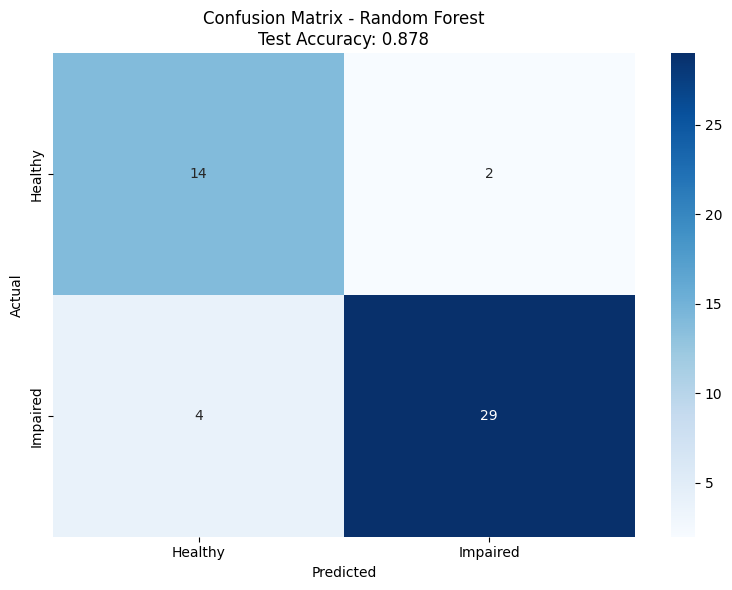


SUMMARY:
Test Accuracy: 0.878
Cross-Validation Accuracy: 0.855 ± 0.097
Training samples: 280
Test samples: 49
Features used: 4 (PSD + SNR normalized features)


In [9]:
# Plot confusion matrix for test set
print("Plotting confusion matrix...")

# Create and plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["Healthy", "Impaired"])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Impaired'],
            yticklabels=['Healthy', 'Impaired'])
plt.title(f'Confusion Matrix - Random Forest\nTest Accuracy: {test_accuracy:.3f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Print summary
print(f"\nSUMMARY:")
print(f"========")
print(f"Test Accuracy: {test_accuracy:.3f}")
print(f"Cross-Validation Accuracy: {cv_mean:.3f} ± {cv_std:.3f}")
print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")
print(f"Features used: {X.shape[1]} (PSD + SNR normalized features)")

In [10]:
POS_LABEL = "Impaired"

def _pos_index(model, pos_label=POS_LABEL):
    return list(model.classes_).index(pos_label)


rf_proba_test = rf_model.predict_proba(X_test)[
    :, _pos_index(rf_model, "Impaired")
]
rf_pred_test = y_pred  # already computed earlier

y_bin = (pd.Series(y_test) == "Impaired").astype(int).to_numpy()
print(
    f"Balanced Accuracy: {balanced_accuracy_score(y_test, rf_pred_test):.3f}")
print(f"Macro F1: {f1_score(y_test, rf_pred_test, average='macro'):.3f}")
print(f"AUROC: {roc_auc_score(y_bin, rf_proba_test):.3f}")
print(f"AUPRC: {average_precision_score(y_bin, rf_proba_test):.3f}")

Balanced Accuracy: 0.877
Macro F1: 0.865
AUROC: 0.890
AUPRC: 0.913


In [11]:
rng = np.random.default_rng(RANDOM_STATE)

# Build a dataframe to keep things aligned
POS_LABEL = "Impaired"
y_true = pd.Series(y_test)
y_hat = pd.Series(y_pred)
y_prob = pd.Series(rf_proba_test)
pid = pd.Series(test_patient_ids)

test_df = pd.DataFrame(
    {
        "y_true": y_true.values,
        "y_hat": y_hat.values,
        "y_prob": y_prob.values,
        "pid": pid.values,
    }
)


# Helper: compute all metrics on a slice of test_df
def _compute_metrics(df):
    # binary array for threshold-free metrics
    y_bin = (df["y_true"] == POS_LABEL).astype(int).to_numpy()

    out = {}
    out["Accuracy"] = accuracy_score(df["y_true"], df["y_hat"])
    out["BalancedAccuracy"] = balanced_accuracy_score(
        df["y_true"], df["y_hat"])
    out["MacroF1"] = f1_score(df["y_true"], df["y_hat"], average="macro")

    # AUROC / AUPRC may be undefined if resample has one class
    try:
        out["AUROC"] = roc_auc_score(y_bin, df["y_prob"].to_numpy())
    except Exception:
        out["AUROC"] = np.nan
    try:
        out["AUPRC"] = average_precision_score(y_bin, df["y_prob"].to_numpy())
    except Exception:
        out["AUPRC"] = np.nan
    return out


# Point estimates on the full test set (for reference)
pt = _compute_metrics(test_df)


# Clustered bootstrap over patients
def bootstrap_patient_ci(test_df, n_boot=5000, alpha=0.05, seed=RANDOM_STATE):
    rng = np.random.default_rng(seed)
    pids = test_df["pid"].unique()
    B = {k: [] for k in ["Accuracy", "BalancedAccuracy", "MacroF1", "AUROC", "AUPRC"]}

    for _ in range(n_boot):
        boot_pids = rng.choice(pids, size=len(pids), replace=True)
        boot_df = pd.concat([test_df[test_df["pid"] == p] for p in boot_pids], axis=0)
        m = _compute_metrics(boot_df)
        for k in B:
            B[k].append(m[k])

    # Percentile CIs (drop NaNs for AUROC/AUPRC)
    ci = {}
    for k, vals in B.items():
        arr = np.asarray(vals, dtype=float)
        arr = arr[~np.isnan(arr)]
        lo, hi = np.quantile(arr, [alpha / 2, 1 - alpha / 2])
        ci[k] = (lo, hi, arr.size)
    return ci, pt


ci, pt = bootstrap_patient_ci(
    test_df, n_boot=5000, alpha=0.05, seed=RANDOM_STATE)


# Pretty print
def _fmt(v):
    return f"{v:.3f}"


print("Patient-clustered 95% bootstrap CIs (percentile):")
for k in ["Accuracy", "BalancedAccuracy", "MacroF1", "AUROC", "AUPRC"]:
    lo, hi, n_used = ci[k]
    print(f" {k:17s} {_fmt(pt[k])} [{_fmt(lo)}, {_fmt(hi)}] (boot n={n_used})")

Patient-clustered 95% bootstrap CIs (percentile):
 Accuracy          0.878 [0.633, 1.000] (boot n=5000)
 BalancedAccuracy  0.877 [0.631, 1.000] (boot n=5000)
 MacroF1           0.865 [0.613, 1.000] (boot n=5000)
 AUROC             0.890 [0.655, 1.000] (boot n=5000)
 AUPRC             0.913 [0.758, 1.000] (boot n=5000)


In [12]:
# === LOPO (leave-one-patient-out) — recording-level evaluation (arms) ===
# Assumes: combined_data, feature_cols, create_rf_model, RANDOM_STATE exist.

POS_LABEL = "Impaired"  # arm label considered positive

X_all = combined_data[feature_cols].to_numpy()
y_all = combined_data["Arm Type"].to_numpy()  # Healthy / Impaired (arm-level)
pids = combined_data["Patient"].to_numpy()

unique_pids = np.array(sorted(pd.unique(pids)))

# Storage for pooled (micro) metrics across all LOPO folds
pooled_y_true = []
pooled_y_pred = []

# Per-patient metrics table
rows = []

for pid in unique_pids:
    test_mask = pids == pid
    train_mask = ~test_mask

    X_tr = X_all[train_mask]
    X_te = X_all[test_mask]
    y_tr = y_all[train_mask]
    y_te = y_all[test_mask]

    # Train one model per patient (train on others, test on this one)
    model = create_rf_model()
    model.fit(X_tr, y_tr)

    y_hat = model.predict(X_te)

    # Collect pooled (micro) predictions
    pooled_y_true.extend(y_te.tolist())
    pooled_y_pred.extend(y_hat.tolist())

    # Per-patient metrics (recording-level within that patient)
    acc = accuracy_score(y_te, y_hat)
    bacc = balanced_accuracy_score(y_te, y_hat)
    f1m = f1_score(y_te, y_hat, average="macro")
    n_imp = int(np.sum(np.array(y_te) == "Impaired"))
    n_hea = int(np.sum(np.array(y_te) == "Healthy"))

    rows.append(
        {
            "Patient": pid,
            "n_recordings": int(test_mask.sum()),
            "n_Healthy": n_hea,
            "n_Impaired": n_imp,
            "Acc": acc,
            "BalancedAcc": bacc,
            "MacroF1": f1m,
        }
    )

# ---- Aggregate results ----
per_patient_df = pd.DataFrame(rows).sort_values(
    "Patient").reset_index(drop=True)

# Macro over patients = mean of per-patient metrics (each patient = 1 unit)
macro_over_patients = {
    "Acc": per_patient_df["Acc"].mean(),
    "BalancedAcc": per_patient_df["BalancedAcc"].mean(),
    "MacroF1": per_patient_df["MacroF1"].mean(),
}

# Micro (pooled) across all LOPO predictions = compute once over all recordings
pooled_y_true = np.array(pooled_y_true)
pooled_y_pred = np.array(pooled_y_pred)

micro_acc = accuracy_score(pooled_y_true, pooled_y_pred)
micro_bacc = balanced_accuracy_score(pooled_y_true, pooled_y_pred)
micro_f1m = f1_score(pooled_y_true, pooled_y_pred, average="macro")

print("=== LOPO (recording-level, arm labels) ===")
print(f"Patients: {len(unique_pids)} | Total recordings: {len(pooled_y_true)}")
print("\n-- Micro (pooled across all LOPO folds) --")
print(f" Accuracy : {micro_acc:.3f}")
print(f" BalancedAccuracy: {micro_bacc:.3f}")
print(f" Macro F1 : {micro_f1m:.3f}")

print("\n-- Macro over patients (mean of per-patient metrics) --")
print(f" Accuracy : {macro_over_patients['Acc']:.3f}")
print(f" BalancedAccuracy: {macro_over_patients['BalancedAcc']:.3f}")
print(f" Macro F1 : {macro_over_patients['MacroF1']:.3f}")

print("\nPer-patient (recording-level) metrics:")
print(per_patient_df.to_string(index=False))

# Optional: quick class-wise pooled report
print("\nPooled classification report (across all LOPO predictions):")
print(classification_report(pooled_y_true, pooled_y_pred, digits=3))

=== LOPO (recording-level, arm labels) ===
Patients: 48 | Total recordings: 329

-- Micro (pooled across all LOPO folds) --
 Accuracy : 0.851
 BalancedAccuracy: 0.856
 Macro F1 : 0.827

-- Macro over patients (mean of per-patient metrics) --
 Accuracy : 0.874
 BalancedAccuracy: 0.870
 Macro F1 : 0.857

Per-patient (recording-level) metrics:
 Patient  n_recordings  n_Healthy  n_Impaired      Acc  BalancedAcc  MacroF1
       1             8          2           6 0.875000     0.750000 0.794872
       2             8          2           6 0.875000     0.916667 0.854545
       3             8          2           6 1.000000     1.000000 1.000000
       4             9          2           7 1.000000     1.000000 1.000000
       5             5          2           3 1.000000     1.000000 1.000000
       6             5          1           4 0.800000     0.875000 0.761905
       7            11          2           9 0.818182     0.888889 0.770833
       8             3          1        